Usage:
* Choose labels to summarize
* Choose data to load
* Run everything

In [1]:
#%matplotlib notebook

In [2]:
# --- third-party ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tabulate

# --- own ---
from datatools import MeasurementDataReader, MeasurementSeries, Measurement, DataTypes, to_ts_data
from datatools import ACC, GYR, MAG
from fhgutils import contextual_recarray_dtype

In [3]:
# Load all data
mdr = MeasurementDataReader(source="tool-tracking-data")
data = mdr.query().filter_by(
    MeasurementSeries == ['pythagoras-07-20200724'],  # RIVETER
    DataTypes == [ACC, GYR, MAG]
).get()

Xt, Xc, y = to_ts_data(data, contextual_recarray_dtype)

[INFO] Read data:  25%|██▌       | 4/16 [00:00<00:00, 33.19it/s, file=MAG-1-154.966.csv]

[INFO] Preparing data from:
  tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:00<00:00, 24.93it/s, file=data-04.annotation]

[WARN] No annoation file available for 02
[WARN] No annoation file available for 01
[INFO] Finished with 4 measurement(s).
[WARN] No label vector are available.
[WARN] No label vector are available.
[WARN] No label vector are available.
[WARN] No label vector are available.
[WARN] No label vector are available.
[WARN] No label vector are available.


In [4]:
duration_arr = None
for i in range(0,3):
    # For each measurement, calculate the duration of each window
    data = np.array(Xt[i])
    t_diff = np.diff(data[:, 0])  # conversion from ms to s?
    t_diff = np.insert(t_diff, 0, 0)  # first diff is zero
    yt = np.array(y[i])
    # duration is the summed diffs of timestamps of consecutive, equal y's
    current_y = -1
    duration = 0
    for i in range(len(yt)):
        previous_y = current_y
        current_y = yt[i]
        if current_y == previous_y:
            duration += t_diff[i]
        else:  # add to our duration array
            if duration_arr is None:
                duration_arr = np.array([[current_y, duration]])
            else:
                duration_arr = np.append(duration_arr, np.array([[previous_y, duration]]), axis=0)
            duration = 0
            previous_y = current_y
duration_df = pd.DataFrame(duration_arr, columns=["y", "duration [s]"])

Text(0.5, 1.0, 'Overview')

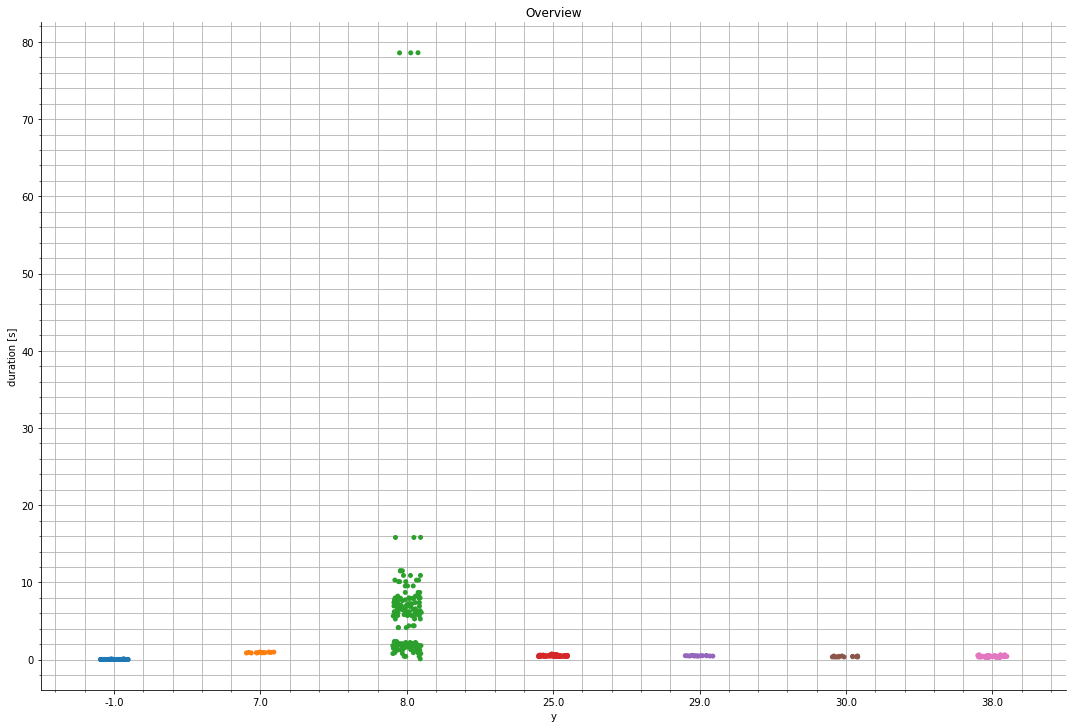

In [5]:
# Categorical scatterplot
sns.catplot(x="y", y="duration [s]", data=duration_df, height=10, aspect=1.5)
plt.minorticks_on()
plt.grid(b=True, which='both')
plt.title("Overview")



Overview:
  Label        Min        Max       Mean     Median        Std    90% Percentile    95% Percentile
-------  ---------  ---------  ---------  ---------  ---------  ----------------  ----------------
     -1  0.0293279   0.116228  0.0338038  0.0293286  0.0154351         0.0387423         0.0387428
      7  0.870075    0.994392  0.926057   0.91045    0.0417514         0.987388          0.989489
      8  0.107538   78.5957    6.31513    5.95355    9.91246           9.55126          10.9121
     25  0.430149    0.716737  0.508398   0.508358   0.0673589         0.583008          0.6741
     29  0.469254    0.557239  0.50722    0.516567   0.0315446         0.553884          0.557239
     30  0.348683    0.479029  0.40066    0.391044   0.0496725         0.475965          0.479029
     38  0.271198    0.635448  0.429701   0.430149   0.0927038         0.55531           0.595017


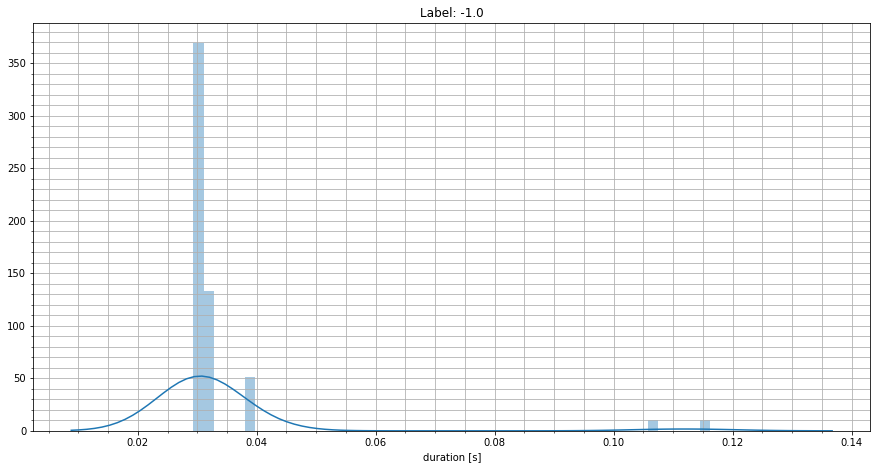

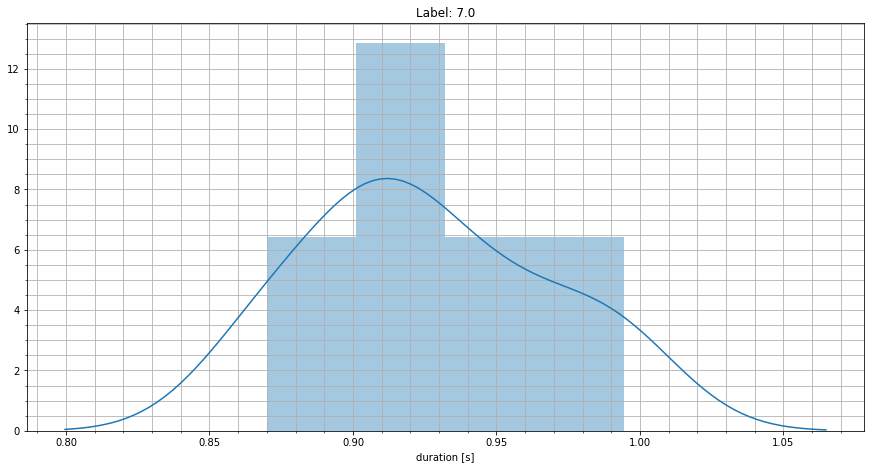

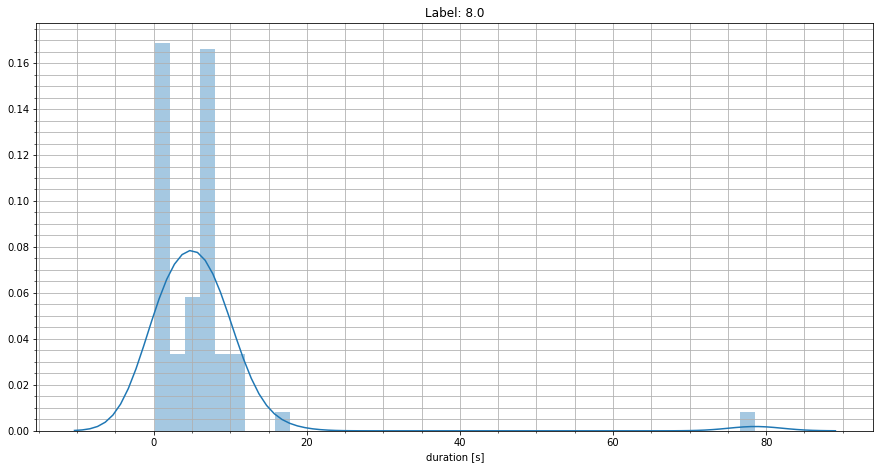

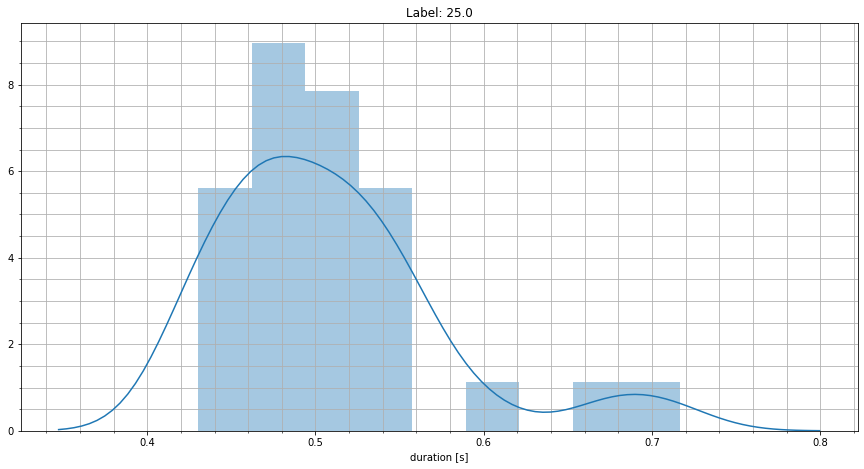

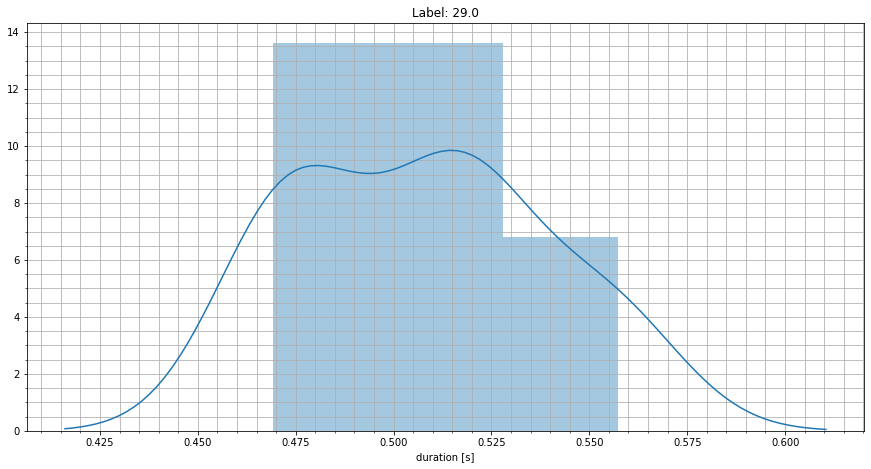

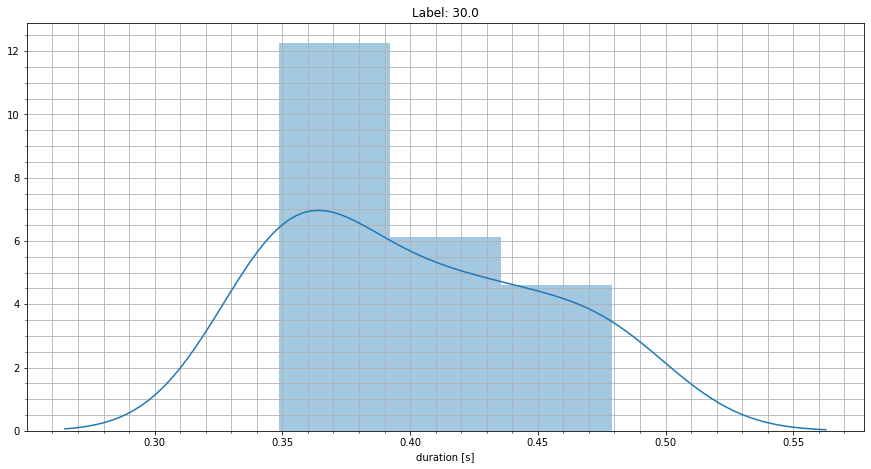

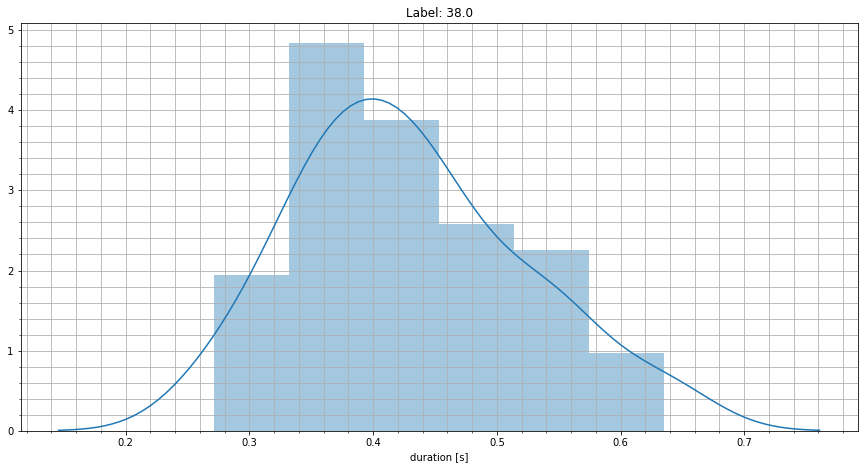

In [6]:
# Detailed single plots
table = []
print("\n\nOverview:")
for y_uniq in np.unique(duration_df.loc[:, "y"]):
    duration_df_uniq = duration_df.loc[duration_df.loc[:, "y"] == y_uniq, "duration [s]"]
    plt.figure(figsize=(15, 7.5))
    sns.distplot(duration_df_uniq)
    plt.title(f"Label: {y_uniq}")
    plt.minorticks_on()
    plt.grid(b=True, which='both')
    table += [[y_uniq, duration_df_uniq.min(),
               duration_df_uniq.max(),
               duration_df_uniq.mean(),
               duration_df_uniq.median(),
               duration_df_uniq.std(),
               duration_df_uniq.quantile(q=0.9),
               duration_df_uniq.quantile(q=0.95)]]
print(tabulate.tabulate(table, headers=["Label", "Min", "Max", "Mean", "Median", "Std", "90% Percentile", "95% Percentile"]))
plt.show()